In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams 
rcParams["font.size"] = 14

# example 1: identify a ricker wavelet in a time-series


Ricker wavelet:
$$
f(t) = \frac{2}{\sqrt{3\sigma} \pi^{1/4}} \left(1 - \left(\frac{t-t_0}{\sigma}\right)^2\right) e^{\frac{-(t-t_0)^2}{2\sigma^2}}
$$

In [3]:
def ricker(t, sigma, t0=0, amplitude=1):
    t = t-t0
    return amplitude * 2/(np.sqrt(3*sigma)*np.pi**0.25) * (1 - (t/sigma)**2)*np.exp(-t**2/(2*sigma**2))

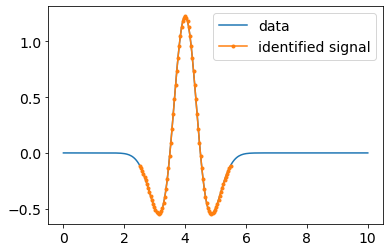

In [4]:
sigma = 0.5
t0 = 4
nt = 256
t = np.linspace(0, 10, nt)
time_series = ricker(t, sigma, t0)

t_ricker = t0 + 3*np.r_[-sigma, sigma]
ricker_inds = (t>=t_ricker.min()) & (t<=t_ricker.max())

plt.plot(t, time_series, label="data")
plt.plot(t[ricker_inds], time_series[ricker_inds], '-', marker=".", label="identified signal")

plt.legend()

## generate data

In [26]:
nt = 256
t = np.linspace(0, 10, nt)
sigma_bounds = np.r_[0.1, 0.5]
amplitude_bounds = np.r_[0.5, 1]
t0_bounds = np.r_[0.1, 9.9]

sigma_threshold = 3

In [27]:
def generate_random_variables(bounds, n):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

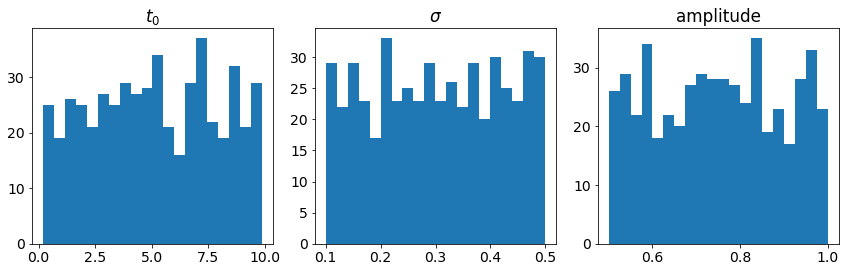

In [38]:
n_train = 512

sigma_train = generate_random_variables(sigma_bounds, n_train)
amplitude_train = generate_random_variables(amplitude_bounds, n_train)
t0_train = generate_random_variables(t0_bounds, n_train)

fig, ax = plt.subplots(1, 3, figsize=(12, 4)) 
for a, var, name in zip(
    ax, 
    [t0_train, sigma_train, amplitude_train], 
    ["$t_0$", "$\sigma$", "amplitude"]
):
    a.hist(var, 20)
    a.set_title(name)

plt.tight_layout()

In [29]:
def generate_data(sigma, t0, amplitude):
    n = len(sigma)
    X = torch.zeros(n, len(t))
    C = torch.zeros(n, len(t))
    
    for i in range(n):
        xi = ricker(t, sigma[i], t0[i], amplitude[i])
        t_ricker = t0[i] + sigma_threshold*np.r_[-sigma[i], sigma[i]]
        ci = ((t>=t_ricker.min()) & (t<=t_ricker.max()))
        
        X[i, :] = torch.from_numpy(xi)
        C[i, :] = torch.from_numpy(ci)
    
    return X, C

In [30]:
X, C = generate_data(sigma_train, t0_train, amplitude_train)

In [47]:
# validation data 

n_valid = 512

sigma_valid = generate_random_variables(sigma_bounds, n_valid)
amplitude_valid = generate_random_variables(amplitude_bounds, n_valid)
t0_valid = generate_random_variables(t0_bounds, n_valid)

X_valid, C_valid = generate_data(sigma_valid, t0_valid, amplitude_valid)

## plot a subset of the data

In [51]:
def plot_data(Xplot, Cplot, nplot=16, dA=1, ax=None):

    inds = np.random.choice(Xplot.size(0), nplot, replace=False)
    
    if ax is None: 
        fig, ax = plt.subplots(1, 1)

    for i, ind in enumerate(inds):
        xi = dA * i + Xplot[ind, :].numpy()
        ci = (Cplot[ind, :].numpy()).astype(bool)
        ax.plot(t, xi, 'C0')
        ax.plot(t[ci], xi[ci], 'C1o', ms=2)

Text(0.5, 1.0, 'subset of training data')

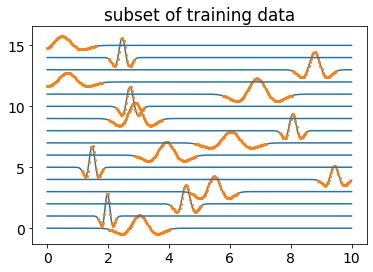

In [52]:
fig, ax = plt.subplots(1, 1)
plot_data(X, C, 16, ax=ax)
ax.set_title("subset of training data")

Text(0.5, 1.0, 'subset of test data')

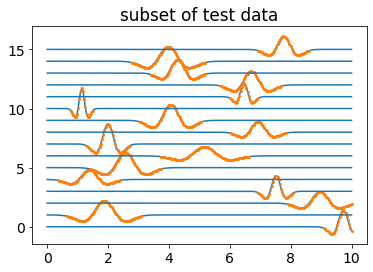

In [53]:
fig, ax = plt.subplots(1, 1)
plot_data(X_valid, C_valid, 16, ax=ax)
ax.set_title("subset of test data")

# design a convolutional network

In [54]:
class ConvNet(nn.Module):
    
    def __init__(self, nt=1, h=0.1):
        super().__init__()
#         self.nt = nt
        self.h = h
    
    def forward(self, X, K, K0=None):
        X = X.unsqueeze(1)
        if K0 is not None:
            X = functional.conv1d(X, K0, stride=1, padding=1)
            
        for Ki in K: 
            z = functional.conv1d(X, Ki, stride=1, padding=1)
            z = functional.instance_norm(z)
            z = functional.relu(z)
            z = functional.conv_transpose1d(z, Ki, stride=1, padding=1)
            X = X - self.h*z
        return X

In [55]:
in_channels = 1
out_channels = 2

n_class = 2

batch_size = 32 
nlayers = 16
net = ConvNet()

# initialize K's
K0 = nn.Parameter(torch.Tensor(out_channels, in_channels, 3))
K0.data = torch.from_numpy(np.float32(np.random.randn(out_channels, in_channels, 3)))

K = []
for i in range(nlayers):
    Ki = nn.Parameter(torch.Tensor(out_channels, out_channels, 3))
    Ki.data = torch.from_numpy(np.float32(np.random.randn(out_channels, out_channels, 3)))
    K.append(Ki)

In [56]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X, W,  C):
#     n = W.shape
#     X = X.view(-1, n[0])
#     print(X.shape, W.shape)
#     S = torch.matmul(X, W) 
#     print(C.shape, C.dtype)
#     S = X
#     print(S.shape, S.dtype)
#     S += bias.unsqueeze(1)
    return lossFunc(X, C.long()), X

In [57]:
# weights for linear classifier    
W = nn.Parameter(torch.randn(nt, 2*nt)*1e-3, requires_grad=True)
# bW = nn.Parameter(torch.randn(n_class)*1e-2, requires_grad=True)

nparout = np.prod(K0.shape) + np.prod(K[0].shape)*nlayers + nlayers

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 214
Total number of data 512


In [58]:
x = net(X, K, K0)
label = C
loss, probs = misfit(x, W, label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ', np.log(2.0))

Initial loss =  0.6060696
Sanity Check =  0.6931471805599453


In [59]:
batchSize = 64

In [60]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': K0}, {'params': K}], #{'params': W}, {'params': bW}, {'params': b}], 
    lr = 1e0, momentum=0
)


In [61]:
for epoch in range(40):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[ind:ind+batchSize, :]
        labels = C[ind:ind+batchSize, :]

        # forward 
        x = net(inputs, K, K0)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        
        lossi.backward()
        optimizer.step()
        g += torch.norm(K0.grad) + torch.norm(K[0].grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  2.461   2.552
2  2.349   0.372
3  2.212   0.184
4  2.096   0.256
5  2.000   0.305
6  1.921   0.302
7  1.850   0.315
8  1.772   0.208
9  1.701   0.173
10  1.647   0.326
11  1.603   0.723
12  1.537   0.375
13  1.487   0.163
14  1.446   0.341
15  1.407   0.225
16  1.375   0.261
17  1.362   0.429
18  1.310   0.172
19  1.300   0.457
20  1.277   0.720
21  1.242   0.356
22  1.218   0.419
23  1.238   1.640
24  1.293   0.428
25  1.235   0.468
26  1.207   0.350
27  1.168   0.244
28  1.145   0.547
29  1.105   0.451
30  1.106   1.095
31  1.094   0.747
32  1.065   0.945
33  1.030   0.487
34  1.010   0.643
35  0.989   0.274
36  0.954   0.242
37  0.948   0.239
38  0.931   0.454
39  0.934   0.559
40  0.945   0.461
Finished Training


In [62]:
xval = net(X_valid, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(xval, dim=1)
_, Cpred = torch.max(S, dim=1)

# label = C
# loss, S = misfit(x, W, bW, label)
# print('Validation loss = ', loss.detach().numpy()) 

# indRed = (Cpred==0).nonzero()
# indBlue = (Cpred==1).nonzero()

# plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.C3')
# plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.C0')

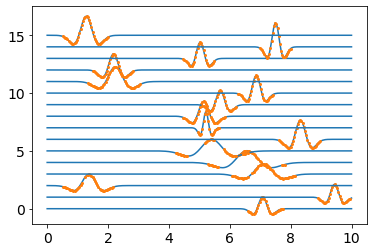

In [63]:
x_train_net = net(X, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(x_train_net, dim=1)
_, Cpred = torch.max(S, dim=1)
plot_data(X, Cpred, 16)

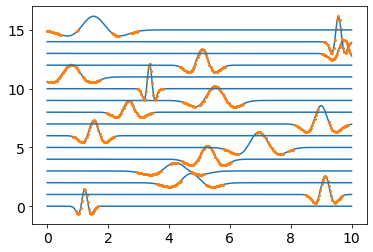

In [64]:
x_valid_net = net(X_valid, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(x_valid_net, dim=1)
_, Cpred_valid = torch.max(S, dim=1)
plot_data(X_valid, Cpred_valid, 16)

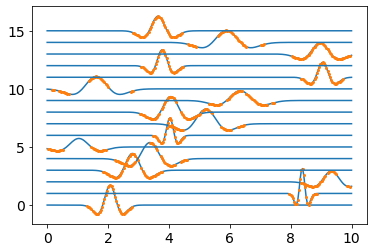

In [65]:
plot_data(X_valid, Cpred_valid, 16)

notes: instead of identifying a single pixel as signal (or not): use a sliding window? --> 